In [112]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.io import wavfile
import IPython.display as ipd
%matplotlib inline

# Lab 8

## Set your names on git!
To make it easier for me to grade, make sure you set your username to your **full name** as it appears on bcourses and set your email to be your Berkeley email account. Make sure to ssh onto the SCF cluster and do the same there.

Git configuration:
- Who are you? `git config --global user.name "Eli Ben-Michael"`
- How can I reach you? `git config --global user.email ebenmichael@berkeley.edu`

## Numpy and Matplotlib: A Basic Fourier Analysis Example


### Creating a Square Wave

We're going to look at reconstructing a square wave:

$$ y(t) = \text{sgn}(\sin(t))$$

First, create a function which returns a square wave

In [27]:
def square(npts=2000):
    """Create a real square wave.
    
    Parameters
    ----------
    npts : int, optional
      Number of points at which to sample the function.    

    Returns
    -------
    t : array
      The t values where the wave was sampled.
    y : array
      The square wave approximation (the final sum of all terms).
    """
    
    # get time points
    t = np.linspace(-np.pi, 2*np.pi, npts)
    
    # create the square wave
    y = np.sign(np.sin(t))

    return t, y

Now let's plot it.

In [50]:
def plot_square(npts=2000):
    """Plot a real sqaure wave

    Parameters
    ----------
    npts : int, optional
      Number of points at which to sample the function.
    """
    # create the square wave
    t, y = square(npts)
    # use the basic plt api
    plt.plot(t, y, label="True Wave")
    plt.grid()
    plt.legend()
    
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title('True Square Wave')

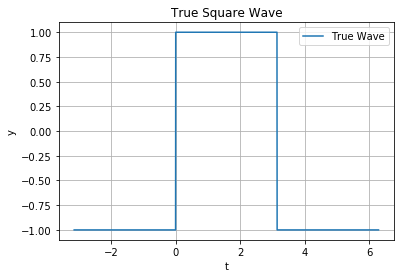

In [51]:
plot_square()

### Reconstructing a Square Wave with a Fourier Series
We can represent a square wave $y(t)$ as an infinite series:

$$ y(t) = \frac{4}{\pi}\sum_{i=0}^{\infty} \frac{1}{2i + 1} \sin((2i + 1) * t)$$

So, we can approximate a square wave with just a few terms of this sum.

In [68]:
def square_approx(nterms=5, npts=2000):
    """Add nterms to construct a square wave.

    Computes an approximation to a square wave using a total of nterms.
    
    Parameters
    ----------
    nterms : int, optional
      Number of terms to use in the sum.
    npts : int, optional
      Number of points at which to sample the function.

    Returns
    -------
    t : array
      The t values where the wave was sampled.
    y : array
      The square wave approximation (the final sum of all terms).
      """
    # create equally spaced time
    t = np.linspace(-np.pi, 2*np.pi, npts)
    # initialize the wave
    y = np.zeros_like(t)

    # add nterms terms in the infinite series
    for i in range(nterms):
        y += 4 / np.pi * (1.0/(2*i+1))*np.sin((2*i+1)* t)

    return t, y

Again, let's plot it

In [69]:
def plot_square_approx(terms, npts=2000):
    """Plot the square wave construction for a list of total number of terms.

    Parameters
    ----------
    terms : int or list of ints
      If a list is given, the plot will be constructed for all terms in it.
    npts : int, optional
      Number of points at which to sample the function.
    """
    
    if isinstance(terms, int):
        # Single term, just put it in a list since the code below expects a list
        terms = [terms]
        
    for nterms in terms:
        t, y = square_approx(nterms, npts)
        plt.plot(t, y, label='n=%s' % nterms)

    plt.grid()
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title('Square wave with n terms')

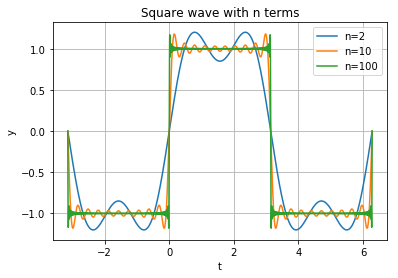

In [70]:
plot_square_approx([2, 10, 100])

And let's overlay the true square wave on top

In [71]:
def plot_both(terms, npts=2000):
    """Plot a true square wave and construction for a list of total number of terms.

    Parameters
    ----------
    terms : int or list of ints
      If a list is given, the plot will be constructed for all terms in it.
    npts : int, optional
      Number of points at which to sample the function.
    """
    
    # use our previous functions!
    
    plot_square(npts)
    plot_square_approx(terms, npts)
    plt.grid()

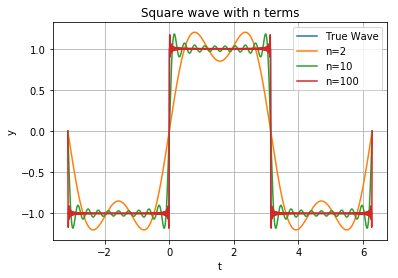

In [75]:
plot_both([2, 10, 100])

We can also plot the individual components of the sum to get some intuition

In [81]:
def square_terms(nterms=5, npts=500):
    """Compute all nterms to construct a square wave.

    Computes an approximation to a square wave using a total of nterms, and
    returns the individual terms as well as the final sum.
    
    Parameters
    ----------
    nterms : int, optional
      Number of terms to use in the sum.
    npts : int, optional
      Number of points at which to sample the function.

    Returns
    -------
    t : array
      The t values where the wave was sampled.
    y : array
      The square wave approximation (the final sum of all terms).
    terms : array of shape (nterms, npts)
      Array with each term of the sum as one row.
      """
    t = np.linspace(-np.pi, 2*np.pi, npts)
    terms = np.zeros((nterms, npts))
    for i in range(nterms):
        terms[i] = 4 / np.pi * (1.0/(2*i+1))*np.sin( (2*i+1)* t)
    y = terms.sum(axis=0)
    return t, y, terms

In [93]:
def plot_square_terms(nterms, npts=2000):
    """Plot individual terms of square wave construction.
    Parameters
    ----------
    nterms : int, optional
      Number of terms to use in the sum.
    npts : int, optional
      Number of points at which to sample the function.
    """
    # first plot the true wave
    plot_square(npts)
    
    # plot individual terms
    t, y, terms = square_terms(nterms)
    for i,term in enumerate(terms):
        plt.plot(t, term, label='freq=%i' % (2*i+1))
    
    # plot the reconstruction
    plt.plot(t, y, color='k', linewidth=2, label='sum')
    plt.legend()
    plt.grid()
    plt.title('Individual components of a square wave')

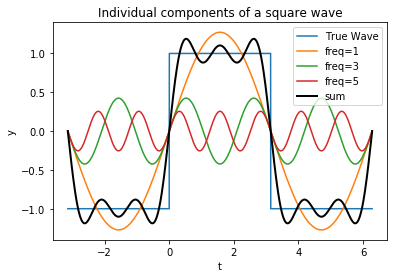

In [94]:
plot_square_terms(3)

### The Gibbs Phenomenon
Notice the weird jump we get even with a lot of terms. It's almost perfect except for at the discontinuity.

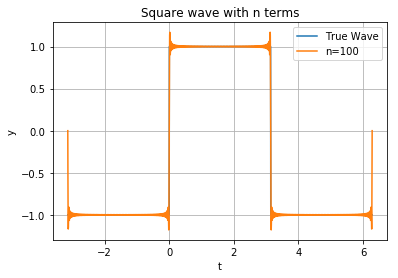

In [99]:
plot_both(100)

This is called the Gibbs Phenomenon, and shows a fundamental difficulty of approximating a discontinuous wave with a sum of continuous waves

### Audio compression with the Fast Fourier Transform
Just like we can represent the square wave as an infinite sum, we can represent a discretely sampled wave as a finite sum over frequencies. We can compute the coefficients of these frequencies with the *Discrete Fourier Transform* (DFT). If we bin up the frequencies into $k=1,2,\ldots$, the coeffient for frequency bin $k$ for wave $y$ is 
$$ c_k = \sum_{n=0}^{N-1} y_n e^\frac{-j2\pi kn}{N}$$
Essentially, the DFT computes the correlation of the signal with each frequency.

On a computer we can get samples from a wave. If the sampling rate is $r$ Hz, and the number of samples is $N$, the frequency corresponding to bin $k$ is 
$$f = \frac{kr}{N}$$

We can compute the coefficients explicitly by computing these sums directly. This is an $O(N^2)$ operation since we compute $N$ sums over $N$ variables. In practice engineers and researchers use the *Fast Fourier Transform* (FFT) to compute the DFT. The FFT uses symmetry of periodic functions to divide and conquer the sum and compute it with $O(N \log N)$ runtime.

Numpy has an FFT inplementation that we will use to reconstruct sound waves.

First, read in some data.

In [116]:
infile = 'data/CallRingingIn.wav'
rate, y = wavfile.read(infile)

What is this?

In [117]:
ipd.Audio(infile)

Exercise: create a function to plot the wave.

In [114]:
def plot_wave(y, rate):
    """P
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    rate : float
      Sampling rate of signal in Hz
    """
    
    ## Your code here

Similar to the square wave, we can approximate the signal by only keeping the frequencies with the highest magnitude. Let's compute the FFT and plot the magnitudes.

/home/ebenmichael/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


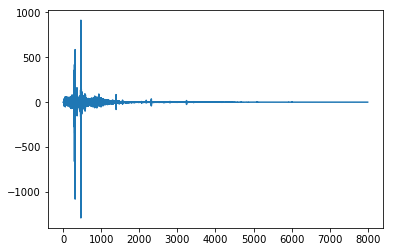

In [126]:
def plot_dft(y, rate):
    """Plot a signal in the frequency domain
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    rate : float
      Sampling rate of signal in Hz    
    """
    
    n = len(y)
    
    # compute the real FFT
    out = np.fft.rfft(y) * 2 / n
    
    # get the frequencies

    freqs = np.arange(n / 2) * rate / n
    plt.plot(freqs, out)

plot_dft(y, rate)

Exercise: given a function which computes the FFT, write a function which zeros out all coefficients except for the top frequencies and then inverts the DFT to get a reconstructed signal.

In [141]:
def fourier_approx(y, rate, frac=0.5):
    """ Approximate a signal with the top frac frequencies
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    rate : float
      Sampling rate of signal in Hz 
    frac : float, optional
      Fraction of frequencies to keep, defaults to 0.5
    
    Returns
    -------
    y_approx : array
      Approximated signal.
    """
    
    # compute (real) fourier transform
    n = len(y)
    out = np.fft.rfft(y)
    
    # compute the magnitudes of the coefficients and keep the top frac
    # zeroing out everything else
    
    ## Your code here
    
    y_approx = np.fft.irfft(out)
    
    return(y_approx)

Now let's plot the signal and the approximated signal side by side.

In [142]:
def plot_approx(y, y_approx, rate, frac=0.5):
    """Plot an audio signal and its approximation.
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    y_approx: ndarray
      Approximated audo signal
    rate : float
      Sampling rate of signal in Hz 
    frac : float, optional
      Fraction of frequencies to keep, defaults to 0.5
    """
    shorter_y = y[:-1]
    # get the time points
    t = np.arange(len(shorter_y), dtype=float)/rate

    # plot the original signal
    plt.plot(t, shorter_y, label='original', lw=1)
    
    # plot the approxiamte signal
    plt.plot(t, y_approx, label='approx', lw=1)
    plt.title('Approx signal {} of the total frequencies'.format(frac * 100))
    plt.xlabel('time (s)')

    plt.grid()
    leg = plt.legend(fancybox=True)
    leg.get_frame().set_alpha(0.5)

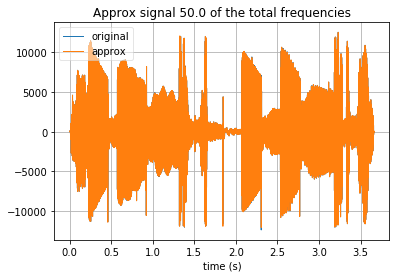

In [148]:
frac = 0.01
y_approx = fourier_approx(y, rate, frac)
plot_approx(y, y_approx, rate)

Now let's convert into a wav file and take a listen.

In [146]:
# linearly rescale raw data to wav range and convert to integers
sound = y_approx.astype(np.int16)
basename, ext = os.path.splitext(infile)
new_filename = '{}_frac{}.wav'.format(basename, 100*frac) 
wavfile.write(new_filename, rate, sound)

In [147]:
ipd.Audio(infile)